In [77]:
import matplotlib.pyplot as plt

%matplotlib inline

In [78]:
dataset = 'classa'

In [79]:
# Read our results

import json

def combine_dict(dict1, dict2):
    for key in dict2.keys():
        if key in dict1:
            dict1[key] = combine_dict(dict1[key], dict2[key])
        else:
            dict1[key] = dict2[key]
    return dict1

def combine_dicts(dicts):
    u = None
    for d in dicts:
        if u is None:
            u = d
        else:
            u = combine_dict(u, d)
    return u

In [80]:
import site

site.addsitedir("/home/xyhang/projects/VCIP2023-grand-challenge/")

from tools.bdrate import BD_RATE, BD_PSNR

In [81]:
from dataclasses import dataclass
from typing_extensions import TypeAlias, List, Dict
import numpy as np

@dataclass
class ResultUnit:
    r: float
    d: float
    t: float

ImageResults: TypeAlias = List[ResultUnit]

class DatasetResults:
    def __init__(self):
        self.img_results: Dict[str, ImageResults] = {}

    def update_image_result(self, img_name, r, d, t):
        self.img_results.setdefault(img_name, []).append(ResultUnit(r=r, d=d, t=t))

    def sort(self):
        for k in self.img_results.keys():
            self.img_results[k].sort(key=lambda x: x.r)

    @property
    def avg_r(self) -> float:
        self.sort()
        results = []
        for rs in zip(*list(self.img_results.values())):
            results.append(np.mean([x.r for x in rs]))
        return results

    @property
    def avg_d(self) -> float:
        self.sort()
        results = []
        for rs in zip(*list(self.img_results.values())):
            results.append(np.mean([x.d for x in rs]))
        return results

    @property
    def avg_t(self) -> float:
        self.sort()
        results = []
        for rs in zip(*list(self.img_results.values())):
            results.append(np.mean([x.t for x in rs]))
        return results

    def _bd_rate_imgwise(self, anchor):
        self.sort()
        anchor.sort()
        ans = {}
        for filename, data in self.img_results.items():
            if filename not in anchor.img_results:
                raise ValueError(f"filename {filename} not in anchor")
            data_anchor = anchor.img_results[filename]
            R1 = [x.r for x in data_anchor]
            D1 = [x.d for x in data_anchor]
            R2 = [x.r for x in data]
            D2 = [x.d for x in data]
            bd_rate = BD_RATE(R1, D1, R2, D2)
            ans[filename] = bd_rate
        return ans

    def bd_rate(self, anchor):
        ans = self._bd_rate_imgwise(anchor)
        return np.mean(list(ans.values()))

    def bd_psnr(self, anchor):
        self.sort()
        anchor.sort()
        ans = []
        for filename, data in self.img_results.items():
            if filename not in anchor.img_results:
                raise ValueError(f"filename {filename} not in anchor")
            data_anchor = anchor.img_results[filename]
            R1 = [x.r for x in data_anchor]
            D1 = [x.d for x in data_anchor]
            R2 = [x.r for x in data]
            D2 = [x.d for x in data]
            bd_rate = BD_PSNR(R1, D1, R2, D2)
            ans.append(bd_rate)
        return np.mean(ans)

In [82]:
def read_json(filename):
    with open(filename, 'r') as f:
        return json.load(f)

In [83]:
import glob

results = glob.glob(f"{dataset}/*.json")

data_ours = combine_dicts([read_json(r) for r in results])

In [84]:
speedups = [0.01, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 3.0]
qscales = [0.3, 0.4, 0.5, 0.6, 0.7]

In [85]:
ours_results = {k: DatasetResults() for k in speedups}

for speedup in speedups:
    for qscale in qscales:
        glob_results = data_ours[f"qscale={qscale}"][f"speedup={speedup}"]
        for filename, result in glob_results.items():
            if filename[:3] != "avg":
                ours_results[speedup].update_image_result(
                    filename, result["bpp"], result["PSNR"], result["t_dec"]
                )

In [86]:
import pandas as pd

def read_xls(file_path, sheet_name):
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    return df

In [87]:
anchors = ['bpg', 'evc', 'jpeg', 'mlic', 'qarv', 'tcm', 'vtm', 'webp']

anchor_results: Dict[str, DatasetResults] = {k: DatasetResults() for k in anchors}

anchors_r = {}
anchors_d = {}
anchors_t = {}

for anchor in anchors:
    if anchor == 'vtm':
        xls_data: pd.DataFrame = read_xls(f"VTM.xls", dataset)
        filename = None
        for index, x in xls_data.iterrows():
            if isinstance(x.Filename, str):
                filename = x.Filename
            anchor_results[anchor].update_image_result(
                filename, x.bpp, x["RGB psnr"], x["Dec Time"] * 4.3057
            )
    else:
        anchor_data = read_json(f"../../anchors/{dataset}/{anchor}/results.json")
        if anchor == 'bpg':
            for t1 in anchor_data.values():
                for t2 in t1.values():
                    for filename, result in t2.items():
                        if filename[:3] != "avg":
                            anchor_results[anchor].update_image_result(
                                filename, result["bpp"], result["PSNR"], result["t_dec"]
                            )
        else:
            for t2 in anchor_data.values():
                for filename, result in t2.items():
                    if filename[:3] != "avg":
                        anchor_results[anchor].update_image_result(
                            filename, result["bpp"], result["PSNR"], result["t_dec"]
                        )

In [88]:
import scipy

def interpolator(R, PSNR):
    lR = np.log(R)

    # integration interval
    min_int = min(PSNR)
    max_int = max(PSNR)

    lin = np.linspace(min_int, max_int, num=100, retstep=True)
    interval = lin[1]
    samples = lin[0]
    v = scipy.interpolate.pchip_interpolate(
        np.sort(PSNR), lR[np.argsort(PSNR)], samples
    )
    return np.exp(v), samples 

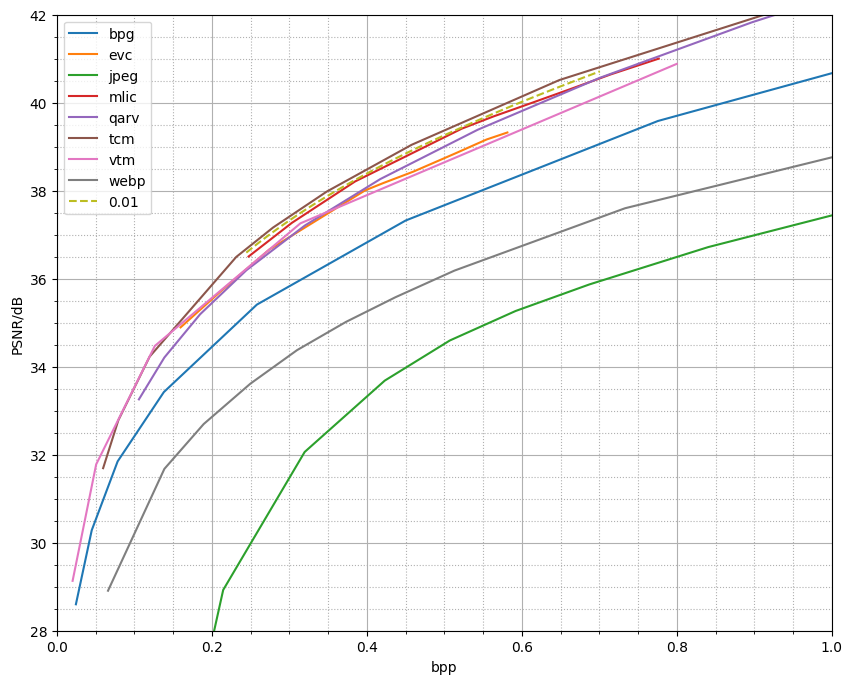

In [89]:
plt.figure(figsize=(10, 8))

for k, v in anchor_results.items():
    r = v.avg_r
    d = v.avg_d
    # r, d = interpolator(r, d)
    plt.plot(r, d, label=k)

for speedup in [0.01]:
    r = ours_results[speedup].avg_r
    d = ours_results[speedup].avg_d
    r, d = interpolator(r, d)

    plt.plot(
        r,
        d,
        linestyle="--",
        label=speedup,
    )
plt.legend()
plt.xlim(0, 1)
plt.ylim(28, 42)

plt.xlabel("bpp")
plt.ylabel("PSNR/dB")
plt.minorticks_on()
plt.grid(which="major", linestyle="-")
plt.grid(which="minor", linestyle=":")

plt.show()

bpg 7.887459101279577 0.0
evc 2.78644299838278 -22.289751240342213
jpeg 0.2819723703644492 199.5423533566235
mlic 29.449085375777 -29.61503225205178
qarv 9.525865304650681 -26.021971621955775
tcm 19.762631173487065 -29.50921526089851
vtm 5.199526036584891 -30.35848249815741
webp 0.6669802954702667 73.22491413899745


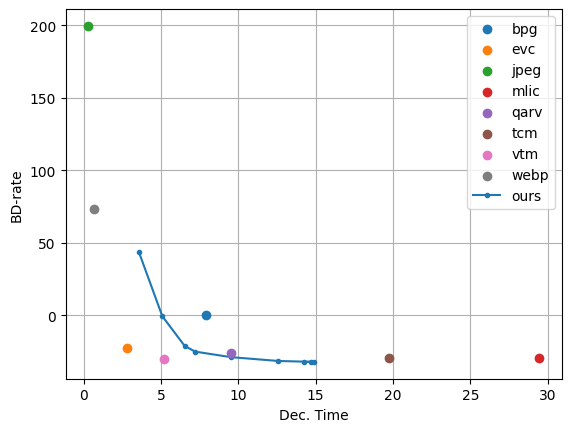

In [90]:
anchor = anchor_results['bpg']

for k, v in anchor_results.items():
    bd = v.bd_rate(anchor)
    t = np.mean(v.avg_t)
    # r, d = interpolator(r, d)
    plt.scatter(t, bd, label=k, zorder=10)
    print(k, t, bd)

ours_bd = []
ours_t = []

for k, v in ours_results.items():
    bd = v.bd_rate(anchor)
    t = np.mean(v.avg_t)
    ours_bd.append(bd)
    ours_t.append(t)

plt.plot(ours_t, ours_bd, label='ours', marker='.')
plt.xlabel("Dec. Time")
plt.ylabel("BD-rate")
plt.grid(zorder=0)
plt.legend()

In [91]:
anchor_results['qarv'].bd_rate(anchor_results['vtm'])

8.595418498292686

In [92]:
anchor_results["tcm"].bd_rate(anchor_results["vtm"])

1.8833605696935258

In [93]:
ours_results[1.0].img_results["DSC08582"]

[ResultUnit(r=0.111838, d=34.59656407811575, t=7.004122018814087),
 ResultUnit(r=0.15802633333333332, d=35.056889557623194, t=6.711113452911377),
 ResultUnit(r=0.2859776666666667, d=35.93464186170034, t=7.957449197769165),
 ResultUnit(r=0.5346936666666666, d=37.41460731007986, t=9.545718908309937),
 ResultUnit(r=0.8464226666666667, d=39.11912968137197, t=9.798119306564331)]

In [94]:
ours_results[0.01].bd_rate(anchor_results["tcm"])

2.120364780303995

In [95]:
ours_results[1.0].bd_rate(anchor_results['qarv'])

-2.0353688627261346

In [96]:
import matplotlib as mpl

def plot_img_results(results: DatasetResults, anchor: DatasetResults):
    ans_results = results._bd_rate_imgwise(anchor)
    ans_results = [(k, v) for k, v in ans_results.items()]
    ans_results.sort(key=lambda x:x[1])
    plt.figure(figsize=(10, 3))

    cm = mpl.colormaps['coolwarm']
    labels, values = zip(*ans_results)
    colors = np.asarray(values)
    colors = colors / (np.abs(colors).max())
    colors = colors / 2 + 0.5
    colors = [cm(k) for k in colors]
    plt.bar(labels, values, color=colors, zorder=10)
    plt.ylabel("BD-rate")
    plt.grid(axis='y', zorder=0)
    plt.xticks(rotation=90)

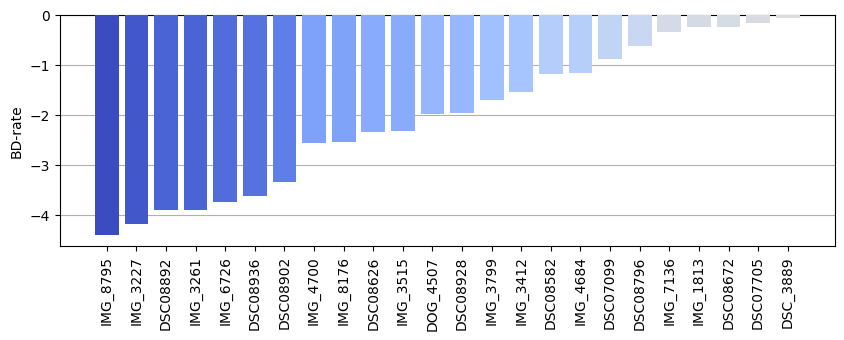

In [97]:
plot_img_results(ours_results[1.0], anchor_results["qarv"])
plt.savefig("ours_qarv_imgwise.png", dpi=300, bbox_inches='tight')
plt.savefig("ours_qarv_imgwise.pdf", bbox_inches="tight")

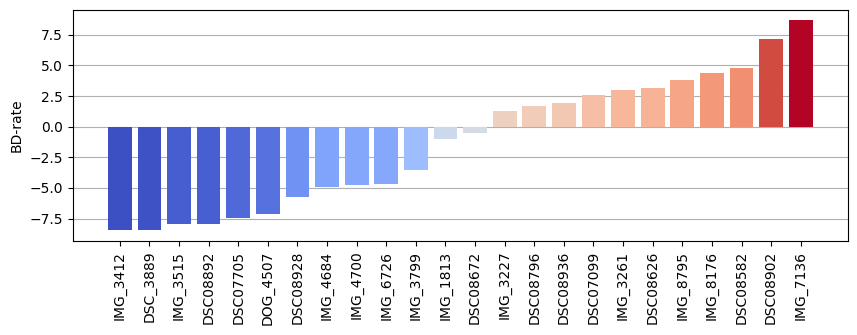

In [98]:
plot_img_results(ours_results[1.0], anchor_results["vtm"])
plt.savefig("ours_vtm_imgwise.png", dpi=300, bbox_inches="tight")
plt.savefig("ours_vtm_imgwise.pdf", bbox_inches="tight")

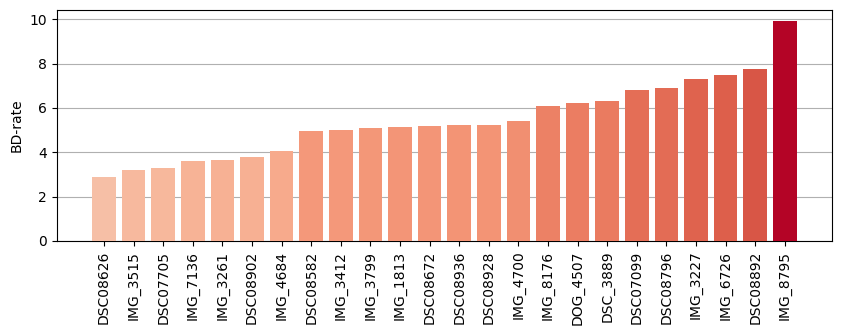

In [99]:
plot_img_results(anchor_results["mlic"], anchor_results["tcm"])

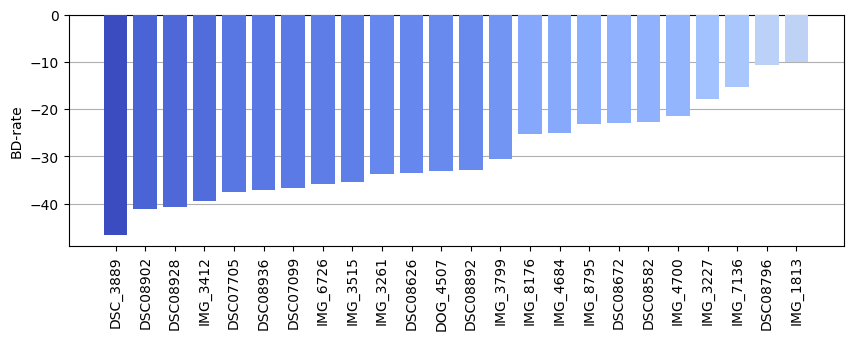

In [100]:
plot_img_results(anchor_results["tcm"], anchor_results["bpg"])

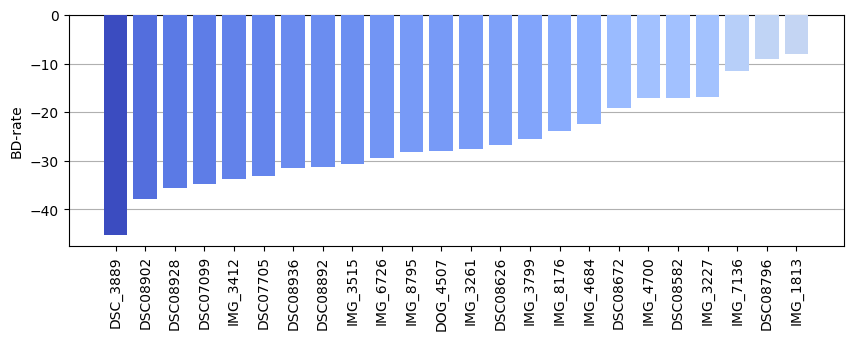

In [101]:
plot_img_results(anchor_results["qarv"], anchor_results["bpg"])

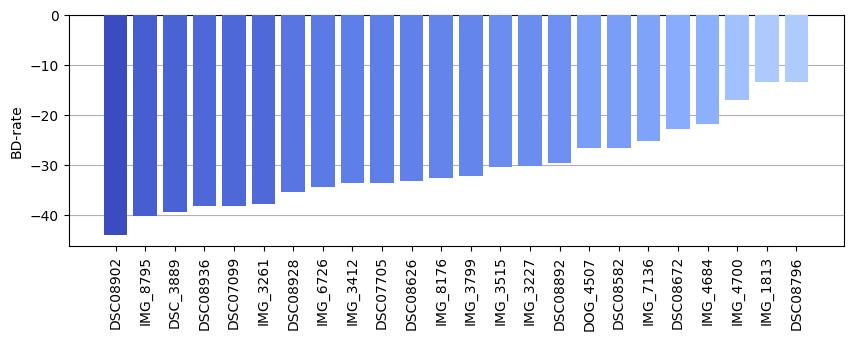

In [102]:
plot_img_results(anchor_results["vtm"], anchor_results["bpg"])